In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import KFold, LeaveOneOut, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline

import dataloader
import bandpower
import preprocessing
from plot_confusion_matrix import plot_confusion_matrix


# Cross validation

Load data from .mat files...
Remove trials:
Number: 41, Session: 20141013, Subject: 7
Number: 47, Session: 20141013, Subject: 8
Remove trials:
Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]
Label: 2, Model: svm, Imblanced: SMOTE, Preprocess: L1select, CV mode: KFold


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


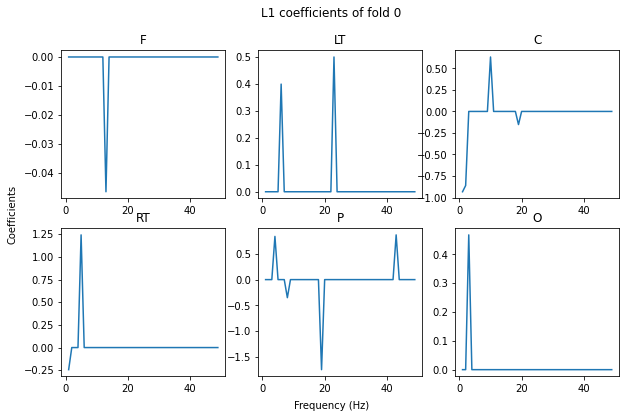

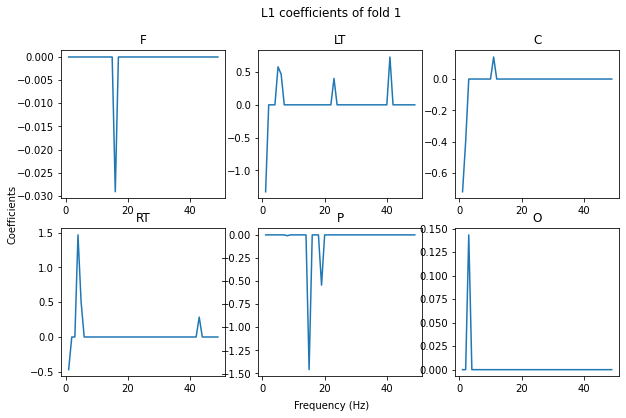

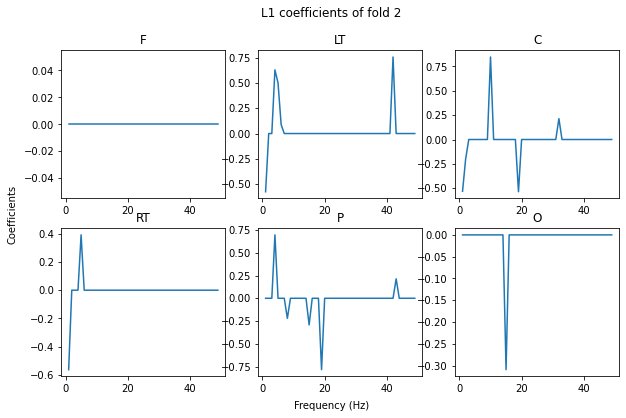

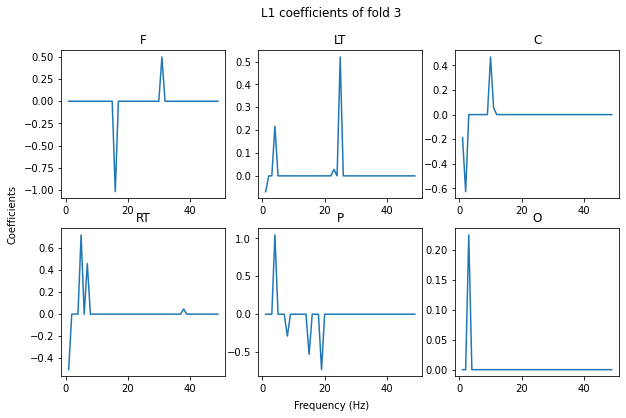

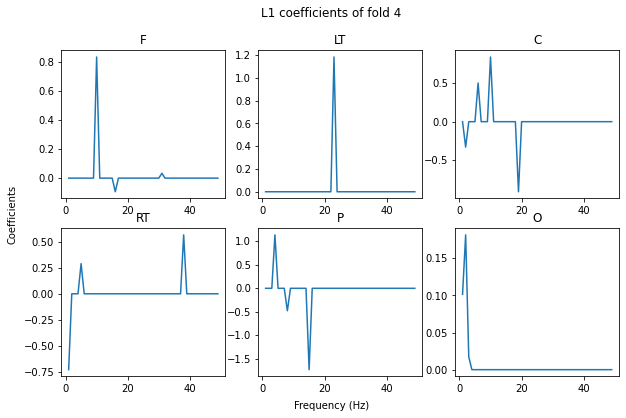

In [33]:
show_acc = False
output_cm = False
use_psd = False
data_folder = 'bp_ica_only'
folder_name = 'BP_classification_bpicaonly_label2'
n_splits = 5

average_regions = 1
reReference = False

label_formats = list(range(2,3))

selected_features = {region:[] for region in ['F','LT','C','RT','P','O']}

for label_format in label_formats:

    X, Y, df_all = dataloader.read_data(label_format=label_format, data_folder=data_folder)
    data = preprocessing.StressData(X, Y, df_all)
    
    # Remove bad trials
    if label_format < 4 and data_folder=='rawdata':
        data.remove_trials()

    if reReference:
        data.reReference('CZ')
    
    if average_regions:
        data.avg_channels_into_regions(mode=average_regions)
        
    # Transform into power
    low, high = list(range(1,50)), list(range(2,51))
    powers, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)
    
    # Use psd as feature
    psds = np.array(psds)
    psds = psds[..., freqs<50]
    freqs = freqs[freqs<50]
    
    if use_psd:
        inputs = psds
        xaxis = np.array(freqs)
    else:
        inputs = powers
        xaxis = np.array(low)

    # Select models
    # TODO: Add coherence as features
    model_names = ['naive', 'svm', 'xgboost', 'random_forest']
    cv_modes = ['KFold', 'LOSO', 'LOO']
    preprocess_methods = ['None', 'StdScale', 'PCAVar', 'PCAL1select', 'L1select', 'SparsePCA']
    imbalanced_methods = ['None', 'SMOTE', 'cost-sensitive']
    
    model_names = ['svm']
    cv_modes = ['KFold']
    preprocess_methods = ['L1select']
    imbalanced_methods = ['SMOTE']
    
    for model_name, cv_mode, preprocess_name, imbalanced_method in itertools.product(model_names, cv_modes, preprocess_methods, imbalanced_methods):

        file_name = '%s/label%d_%s_%s_%s_%s.csv'%(folder_name, label_format, model_name, imbalanced_method, cv_mode, preprocess_name)
        description = 'Label: %d, Model: %s, Imblanced: %s, Preprocess: %s, CV mode: %s'%(label_format, model_name, imbalanced_method, preprocess_name, cv_mode)
        print(description)
        
        num_sample = len(data.EEG_list)
        if average_regions:
            X_power = np.array(inputs)
            X_power = X_power.reshape((len(X_power),-1))
        else:
            # Average over channels
            X_power = np.zeros((num_sample, inputs[1].shape[1]))
            for i in range(len(X)):
                X_power[i,:] = np.mean(inputs[i],0)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=23)
        loo = LeaveOneOut()
        S = data.df_all['subject'].values
        if cv_mode == 'KFold':
            folds = kf.split(X_power)
        elif cv_mode == 'LOO':
            folds = loo.split(X_power)
        else:    # Leave one subject out
            folds = np.unique(S)

        train_acc_list = []
        val_acc_list = []
        train_recall_list = []
        val_recall_list = []
        train_prec_list = []
        val_prec_list = []
        train_f1_list = []
        val_f1_list = []
        num_val_list = []
        chance_list = []
        fold_name_list = []
        
        train_confusion = np.zeros((2,2))
        val_confusion = np.zeros((2,2))
        
        if show_acc:
            print('Sub  \t Chance\t | Train | Val')
        for i_fold, fold in enumerate(folds):
            if cv_mode in ['KFold','LOO']:
                train_indices = fold[0]
                val_indices = fold[1]
            else:
                subID = fold
                train_indices = np.where(S!=subID)[0]
                val_indices = np.where(S==subID)[0]

            X_train, Y_train = X_power[train_indices,...], data.labels[train_indices]
            X_val, Y_val = X_power[val_indices,...], data.labels[val_indices]

            # Preprocessing features
            if preprocess_name == 'StdScale':
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            elif preprocess_name == 'L1select':
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
                X_train, X_val, sel_ = preprocessing.select_features(X_train, X_val, Y_train)
                
                # Plot L1 selected features
                fig, axs = plt.subplots(2, 3, figsize=(10,6))
                for i_channel in range(6):

                    row, col = i_channel//3, i_channel%3

                    coef = sel_.estimator_.coef_[0,i_channel*len(xaxis):(i_channel+1)*len(xaxis)]
                    
                    axs[row][col].plot(xaxis, coef)
                    axs[row][col].set_title(data.df_all.loc[0,'channels'][i_channel])

                    selected_features[data.df_all.loc[0,'channels'][i_channel]].append(list(xaxis[np.where(coef!=0)[0]]))
                    
                fig.suptitle('L1 coefficients of fold %d'%(i_fold))
                fig.text(0.5, 0.05, 'Frequency (Hz)', ha='center')
                fig.text(0.05, 0.5, 'Coefficients', va='center', rotation='vertical')
                fig.savefig('./results/l1_select_fold%d.png'%(i_fold))
                
            elif preprocess_name in ['PCAVar', 'PCAL1select', 'SparsePCA']:
                if preprocess_name == 'PCAVar':
                    n_components = 0.9
                elif preprocess_name == 'PCAL1select':
                    n_components = np.min(X_train.shape)
                elif preprocess_name == 'SparsePCA':
                    n_components = 10
                
                scaler, pca = StandardScaler(), PCA(n_components=n_components)
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
                
                X_train = pca.fit_transform(X_train)
                X_val = pca.transform(X_val)
                
                if preprocess_name == 'PCAL1select':
                    X_train, X_val = preprocessing.select_features(X_train, X_val, Y_train)
            
            # Resample training data
            if imbalanced_method == 'SMOTE':
                sm = SMOTE(random_state=23)
                X_train, Y_train = sm.fit_resample(X_train, Y_train)

            # Train classifier
            num_neg, num_pos = tuple(np.bincount(Y_train))
            if model_name in ['svm','xgboost','naive','random_forest']:
                if model_name == 'svm':
                    if imbalanced_method == 'cost-sensitive':
                        clf = svm.SVC(class_weight='balanced')
                    else:
                        clf = svm.SVC()
                elif model_name == 'xgboost':
                    if imbalanced_method == 'cost-sensitive':
                        clf = xgb.XGBClassifier(scale_pos_weight=num_neg/num_pos)
                    else:
                        clf = xgb.XGBClassifier()
                elif model_name == 'naive':
                    if imbalanced_method == 'cost-sensitive':
                        clf = GaussianNB(priors = [num_pos/len(Y_train), num_neg/len(Y_train)])
                    else:
                        clf = GaussianNB()
                elif model_name == 'random_forest':
                    if imbalanced_method == 'cost-sensitive':
                        clf = RandomForestClassifier(max_depth=2, class_weight='balanced', random_state=23)
                    else:
                        clf = RandomForestClassifier(max_depth=2)
                        
                clf.fit(X_train, Y_train)

                # Test classifier
                pred_train = clf.predict(X_train)
                pred_val = clf.predict(X_val)
                
                train_confusion += confusion_matrix(Y_train, pred_train, labels=[0,1])
                val_confusion += confusion_matrix(Y_val, pred_val, labels=[0,1])
                
                train_acc = accuracy_score(Y_train, pred_train)
                val_acc = accuracy_score(Y_val, pred_val)
                
                train_recall = recall_score(Y_train, pred_train)
                val_recall = recall_score(Y_val, pred_val)
                
                train_prec = precision_score(Y_train, pred_train)
                val_prec = precision_score(Y_val, pred_val)
                
                train_f1 = f1_score(Y_train, pred_train)
                val_f1 = f1_score(Y_val, pred_val)
                
            fold_name = 'Fold %d'%(i_fold) if cv_mode in ['KFold','LOO'] else 'Sub %d'%(subID)
            chance = np.sum(Y_train)/len(Y_train)
            chance = (1-chance) if chance<0.5 else chance

            train_acc_list.append(train_acc)
            val_acc_list.append(val_acc)
            train_recall_list.append(train_recall)
            val_recall_list.append(val_recall)
            train_prec_list.append(train_prec)
            val_prec_list.append(val_prec)
            train_f1_list.append(train_f1)
            val_f1_list.append(val_f1)
            num_val_list.append(len(Y_val))
            fold_name_list.append(fold_name)
            chance_list.append(chance)

            if show_acc:
                print('%s\t %.1f%%\t | %.1f%% | %.1f%%'%(fold_name, chance*100, train_acc*100, val_acc*100))
            
            if output_cm:
                fileName_cm = './results/' + file_name[:file_name.find('.')] + '_' + fold_name
                plot_confusion_matrix(Y_train, pred_train, np.array(['Normal','Increase']), 
                                     fileName='%s_train.png'%(fileName_cm), title=fold_name)
                plot_confusion_matrix(Y_val, pred_val, np.array(['Normal','Increase']), 
                                     fileName='%s_val.png'%(fileName_cm), title=fold_name)
        
        tp, fp = val_confusion[1,1], val_confusion[0,1]
        tn, fn = val_confusion[0,0], val_confusion[1,0]
        
        avg_acc = (tp+tn) / (tp+tn+fp+fn)
        avg_recall = tp / (tp+fn) if tp+fn!=0 else 0
        avg_prec = tp / (tp+fp) if tp+fp!=0 else 0
        avg_f1 = 2 / (1/avg_recall+1/avg_prec) if avg_recall!=0 and avg_prec!=0 else 0
        
        if show_acc:
            print('Average val acc: %.1f%%'%(avg_acc*100))

        # Save result as csv file
        df_result = pd.DataFrame({description: fold_name_list, 'Chance_train_acc': chance_list, 
                                  'Train_recall' : train_recall_list, 'Val_recall': val_recall_list,
                                  'Train_precision' : train_prec_list, 'Val_precision': val_prec_list,
                                  'Train_f1' : train_f1_list, 'Val_f1': val_f1_list,
                                  'Train_acc': train_acc_list, 'Val_acc': val_acc_list})
        df_result.loc[len(df_result),description] = 'Average'
        df_result.loc[len(df_result)-1, 'Val_acc'] = avg_acc
        df_result.loc[len(df_result)-1, 'Val_recall'] = avg_recall
        df_result.loc[len(df_result)-1, 'Val_precision'] = avg_prec
        df_result.loc[len(df_result)-1, 'Val_f1'] = avg_f1
        df_result.to_csv('./results/%s'%(file_name))

# Save L1 selected features

In [37]:
df = pd.DataFrame.from_dict(selected_features)

In [38]:
df.to_csv('results/L1_BP/select.csv')

# K-Fold Cross Validation for hyperparameter tuning

In [35]:
def get_pipeline_parameters(model):
    
    if model == 'svm':
        pipeline = Pipeline(
            [
                ('scale',StandardScaler()),
                ('select_features',SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))),
                ('resample',SMOTE(random_state=23)),
                ('clf',svm.SVC())
            ]
        )
        parameters = {
            'clf__C' : np.linspace(0.1, 30, 300),
            'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
        }
        name_parameters = ['C', 'kernel']
    elif model == 'random_forest':
        pipeline = Pipeline(
            [
                ('resample',SMOTE(random_state=23)),
                ('clf',RandomForestClassifier())
            ]
        )
        parameters = {
            'clf__n_estimators' : np.linspace(10,100,10).astype('int'),
            'clf__max_depth' : np.linspace(1,100,10).astype('int')
        }
        name_parameters = ['n_estimators', 'max_depth']
        
    return pipeline, parameters, name_parameters

In [36]:
label_format = 4
data_folder = 'rest'

signals, Y, df_all = dataloader.read_data(label_format=label_format, data_folder=data_folder)
data = preprocessing.StressData(signals, Y, df_all)
    
# Remove bad trials
if label_format < 4:
    data.remove_trials()

# Average into regions
data.avg_channels_into_regions(mode=1)

# Transform into power
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)
powers = np.array(powers).reshape((len(powers),-1))
psds = np.array(psds)
psds = psds[...,freqs<50].reshape((len(psds),-1))
freqs = freqs[freqs<50]

X, Y = psds, data.labels

model = 'random_forest'
pipeline, parameters, name_parameters = get_pipeline_parameters(model)

scores = ['accuracy', 'recall', 'precision', 'f1']
cv = KFold(n_splits=10, shuffle=True, random_state=23)

random_cv = RandomizedSearchCV(pipeline, parameters, n_iter=100, cv=cv, scoring=scores, refit='f1', n_jobs=-1, verbose=3, return_train_score=True)
grid_cv = GridSearchCV(pipeline, parameters, cv=cv, scoring=scores, refit='f1', n_jobs=-1, verbose=3, return_train_score=True)

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [37]:
grid_cv.fit(X, Y)

print('Best Parameters: ', grid_cv.best_params_)
print('Best f1 scores: ', grid_cv.best_score_)
print('Best recall: ', np.max(grid_cv.cv_results_['mean_test_recall']))
print('Best precision: ', np.max(grid_cv.cv_results_['mean_test_precision']))
print('Best accuracy: ', np.max(grid_cv.cv_results_['mean_test_accuracy']))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:  1.0min remaining:    0.4s


Best Parameters:  {'clf__max_depth': 1, 'clf__n_estimators': 20}
Best f1 scores:  0.55
Best recall:  0.65
Best precision:  0.6
Best accuracy:  0.6833333333333333


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


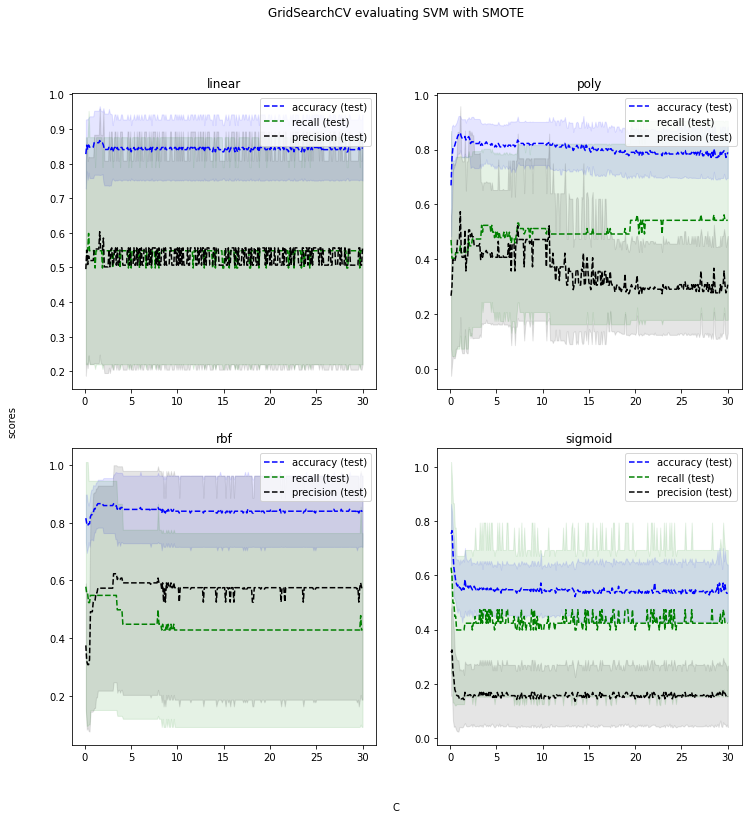

In [4]:
# Plot results for svm
fig, axs = plt.subplots(2,2, figsize=(12,12))
fig.suptitle('GridSearchCV evaluating %s with SMOTE'%(model))
fig.text(0.5, 0.05, 'C', ha='center')
fig.text(0.05, 0.5, 'scores', va='center', rotation='vertical')
X_axis = np.array(results['param_clf__%s'%(name_parameters[0])].data, dtype=float)[::4]

for i_plot, kernel in enumerate(parameters['clf__%s'%(name_parameters[1])]):
    
    row, col = i_plot//2, i_plot%2
    
    for scorer, color in zip(scores, ['b','g','k']):
        
        for sample, style in (('train','-'), ('test','--')):
            
            if sample == 'train':
                continue
            
            sample_score_mean = results['mean_%s_%s'%(sample, scorer)][i_plot::4]
            sample_score_std = results['std_%s_%s'%(sample, scorer)][i_plot::4]

            axs[row,col].fill_between(X_axis, sample_score_mean+sample_score_std, sample_score_mean-sample_score_std,
                                      alpha=0.1 if sample=='test' else 0, color=color)
            axs[row,col].plot(X_axis, sample_score_mean, style, color=color,
                              alpha=1 if sample=='test' else 0.7, label='%s (%s)'%(scorer, sample))
            
            axs[row, col].legend()
            axs[row, col].set_title(kernel)

# Find highest performance among multiple csv files

In [3]:
import glob

In [6]:
data_name = 'PSD_classification_raw_label2'
save = True

val_methods = ['KFold', 'LOO', 'LOSO']
df_record = pd.read_csv('./results/record.csv', index_col=0)
list_result = []
list_result.append(data_name)
for val_method in val_methods:
    
    
    files = glob.glob('./results/%s/*_%s_*.csv'%(data_name, val_method))
    max_metric, max_file = 0, ''

    for file in files:

        df = pd.read_csv(file)
        metric = df.loc[len(df)-1, 'Val_f1']

        if metric>max_metric:
            max_metric, max_file = metric, file

    df = pd.read_csv(max_file)
    print(max_file)
    print('Best accuracy: ', df.loc[len(df)-1, 'Val_acc'])
    print('Best recall: ', df.loc[len(df)-1, 'Val_recall'])
    print('Best precision: ', df.loc[len(df)-1, 'Val_precision'])
    print('Best f1: ', df.loc[len(df)-1, 'Val_f1'])
    list_result.append(max_file.split('/')[-1])
    
    for metric in ['Val_acc', 'Val_recall', 'Val_precision', 'Val_f1']:
        list_result.append(df.loc[len(df)-1, metric])
        
if save:
    df_record.loc[len(df_record)] = list_result
    df_record.to_csv('./results/record.csv')


./results/PSD_classification_raw_label2/label2_random_forest_SMOTE_KFold_StdScale.csv
Best accuracy:  0.8089171974522293
Best recall:  0.5833333333333334
Best precision:  0.4117647058823529
Best f1:  0.4827586206896552
./results/PSD_classification_raw_label2/label2_random_forest_cost-sensitive_LOO_None.csv
Best accuracy:  0.8025477707006371
Best recall:  0.5
Best precision:  0.3870967741935484
Best f1:  0.4363636363636363
./results/PSD_classification_raw_label2/label2_random_forest_SMOTE_LOSO_StdScale.csv
Best accuracy:  0.7707006369426752
Best recall:  0.5416666666666666
Best precision:  0.34210526315789475
Best f1:  0.41935483870967744


In [2]:
'''
# Reset record.csv
keys = {}
keys['input_target'] = []
for val_method in ['KFold', 'LOO', 'LOSO']:
    for metric in ['model', 'accuracy', 'recall', 'precision', 'f1']:
        keys[val_method+'_'+metric] = []

df = pd.DataFrame(keys)
df.to_csv('./results/record.csv')
'''